In [1]:
import hypernetx as hnx
import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import random

 No module named 'celluloid'. If you need to use hypernetx.algorithms.contagion, please install additional packages by running the following command: pip install .['all']


In [59]:
## Set up. 
dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v0_hypergraphSimulations/getMultiwayInteractions_fromBPChains/'

## Read in example file
exMat = np.loadtxt(f'{dataDir}chains_500_10000_1500_1681171613/chain_dist_8729.txt')

nrow = exMat.shape[0]
cutoff = 500

In [106]:
distPattern = "chain_dist_*.txt"
matching_files = glob.glob(f'{dataDir}chains_500_10000_1500_1681171613/{distPattern}')

random.seed(10)
sampleSize = 4

avgMat = None
dfs = []

for f in random.sample(matching_files,sampleSize):
    oneChain = np.loadtxt(f)
    if avgMat is None:
        avgMat = oneChain
    else:
        avgMat += (oneChain / sampleSize)
    chainDF = makeIncDF_fromChainDists(oneChain)
    print(chainDF.shape)
    dfs.append(chainDF)

combined_incDF = pd.concat(dfs,axis=1)
combined_incDF.shape

(500, 4327)
(500, 4295)
(500, 4251)
(500, 4009)


(500, 16882)

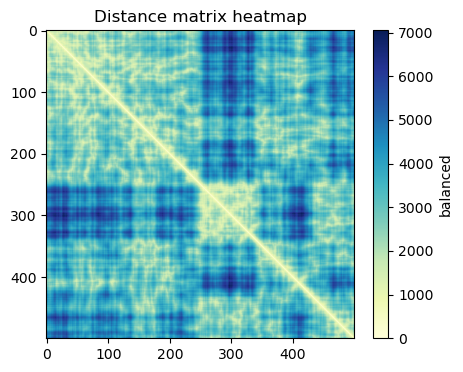

In [107]:
plt.figure(figsize=(6, 4))
im = plt.imshow(avgMat, cmap="YlGnBu")
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title("Distance matrix heatmap")
plt.show()

In [108]:
oneChain = makeIncDF_fromChainDists(avgMat)
oneChain.shape

(500, 0)

In [93]:
def makeIncDF_fromChainDists(chainMat):
    nrow = chainMat.shape[0]
    index_range = range(nrow)
    df = pd.DataFrame(index=index_range)
    columns_to_add = []
    chainMat_triu = np.triu(chainMat, k=1)
    counter = 0
    for i in range(nrow):
        condition1 = (0 < chainMat_triu[i, :])
        condition2 = (chainMat_triu[i, :] < cutoff)
        possNeighbors = list(np.where(condition1 & condition2)[0])
        if(possNeighbors):
            for ix in range(2,len(possNeighbors)):
                for comb in combinations(possNeighbors,ix):
                    d = chainMat_triu[np.ix_(comb,comb)]
                    if d.max() <= cutoff:
                        counter += 1
                        new_column = np.zeros(nrow)
                        new_column[list(comb)] = 1
                        columns_to_add.append(pd.Series(new_column, name=f'Read_{counter}'))

    df = pd.concat([df] + columns_to_add, axis=1)
    return(df)

In [5]:
## Convert incidence matrix to 2d hiC matrix
def makeHiC_fromInc(incDF):
    nrow = incDF.shape[0]
    ncol = incDF.shape[1]
    binIDs = list(incDF.index)
    df = pd.DataFrame(np.zeros(shape = (nrow,nrow)), index=binIDs, columns=binIDs)
    for read in incDF.columns:
        arr = incDF[read][incDF[read] == 1].index
        for a in arr:
            df.loc[a][a] += 1
        combs = list(combinations(arr,2))
        for c in combs:
            df.loc[c[0]][c[1]] += 1
            df.loc[c[1]][c[0]] += 1
    return(df)

In [109]:
hic_mat = makeHiC_fromInc(df)

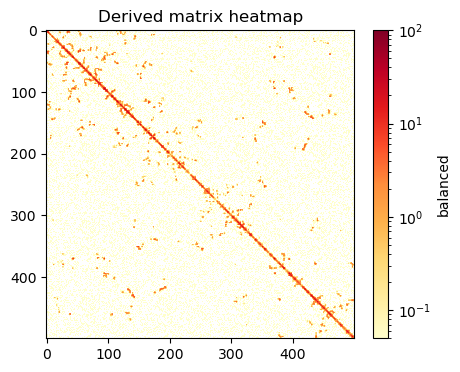

In [115]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(6, 4))
im = plt.imshow(hic_mat, cmap="YlOrRd",norm = LogNorm(vmax=100, vmin = 0.05))
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title("Derived matrix heatmap")
plt.show()

In [111]:
card = df.sum()

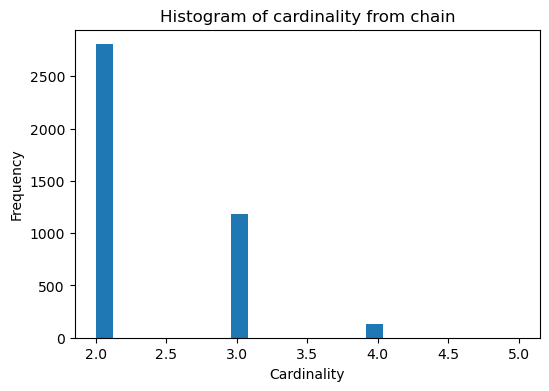

In [112]:
# Generate a histogram
plt.figure(figsize=(6,4))
plt.hist(card, bins='auto')

# Add labels and title
plt.xlabel('Cardinality')
plt.ylabel('Frequency')
plt.title('Histogram of cardinality from chain')

# Display the histogram
plt.show()

In [133]:
incDF = df2 = pd.DataFrame(np.array([[1,0,1,0,1], [0,1,0,3,0],[0,1,1,3,1],[1,1,1,0,1],[1,1,1,0,1]]),
    columns=['R1', 'R2', 'R3','R4',"R5"])
incDF

,R1,R2,R3,R4,R5
0,1,0,1,0,1
1,0,1,0,3,0
2,0,1,1,3,1
3,1,1,1,0,1
4,1,1,1,0,1


/gpfs/commons/home/ajoglekar/.conda/envs/noush_base/envs/hypergraph_poreC/lib/python3.10/site-packages/hypernetx/classes/entity.py:1387: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  properties = props.combine_first(self.properties)
/gpfs/commons/home/ajoglekar/.conda/envs/noush_base/envs/hypergraph_poreC/lib/python3.10/site-packages/hypernetx/classes/entity.py:1390: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  properties[self._misc_props_col] = self.properties[
/gpfs/commons/home/ajoglekar/.conda/envs/noush_base/envs/hypergraph_poreC/lib/python3.10/site-packages/hypernetx/classes/entity.py:1387: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  properties = props.combine_first(self.properties)
/gpfs/commons/home/ajoglekar/.conda/envs/noush_base/envs/hypergraph_poreC/lib/python3.10/site-packages/hypernetx/classes/entity.

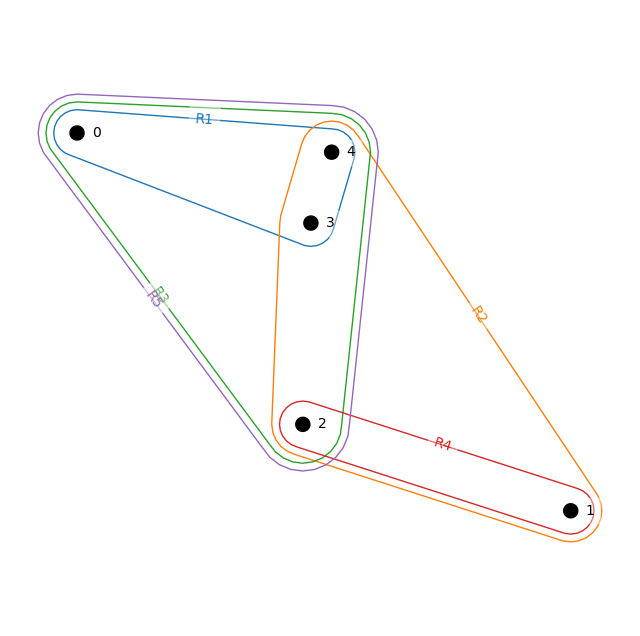

In [134]:
H = hnx.Hypergraph.from_incidence_dataframe(incDF)
hnx.draw(H)